# Attribute Correlation Statistics (ACSDb) from Wikipedia Tables

## Reading data from csv
The csv that has been built using the other notebook

In [1]:
import pandas as pd

file_path = 'wikitables.csv'
data = pd.read_csv(file_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15273 entries, 0 to 15272
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             15273 non-null  int64 
 1   uid            15273 non-null  object
 2   url            15273 non-null  object
 3   title          15273 non-null  object
 4   section_title  13838 non-null  object
 5   section_text   5931 non-null   object
 6   intro          15136 non-null  object
 7   schema         15273 non-null  object
 8   data           15273 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.0+ MB


## Parsing each table to a dataframe
for viewing purposes

In [2]:
import ast

def parse_table(schema, data):
    columns = ast.literal_eval(schema)
    data_list = ast.literal_eval(data)

    rows = []
    for row in data_list:
        row_values = [entry[0] for entry in row]
        rows.append(row_values)
    
    return pd.DataFrame(rows, columns=columns)

In [3]:
parse_table(data.iloc[0]['schema'], data.iloc[0]['data'])

,Year,Award,Result,Category/Recipient
0,1969,FIPRESCI prize,Won,for Andrei Rublev
1,1972,Grand Prix Spécial du Jury,Won,for Solaris
2,1972,Palme d'Or,Nominated,for Solaris
3,1980,Prize of the Ecumenical Jury,Won,for Stalker
4,1983,Grand Prix du cinéma de creation,Won,for Nostalghia
5,1983,FIPRESCI prize,Won,for Nostalghia
6,1983,Prize of the Ecumenical Jury,Won,for Nostalghia
7,1983,Palme d'Or,Nominated,for Nostalghia
8,1986,FIPRESCI prize,Won,for The Sacrifice
9,1986,Prize of the Ecumenical Jury,Won,for The Sacrifice


## Creating ACSDb

In [4]:
from collections import defaultdict
from urllib.parse import urlparse

def create_acs(relations):
    A = defaultdict(int)
    attribute_counts = defaultdict(int)

    for relation in relations:
        # Computing the schema frequency
        schema = frozenset(relation['schema'])
        A[schema] += 1
        
        # Computing the attribute frequency
        for attribute in schema:
            attribute_counts[attribute] += 1

    return A, attribute_counts

In [5]:
def compute_probabilities(A, attribute_counts):
    total_schemas = sum(A.values())
    attribute_prob = {}
    conditional_prob = defaultdict(dict)

    # Computing attribute probabilities
    for attribute, count in attribute_counts.items():
        attribute_clean = attribute.strip()
        attribute_prob[attribute_clean] = count / total_schemas if total_schemas > 0 else 0
    
    # Computing conditional probabilities (att1, att2)
    for schema, schema_count in A.items():
        for attr1 in schema:
            attr1_clean = attr1.strip()
            for attr2 in schema:
                attr2_clean = attr2.strip()
                if attr1_clean != attr2_clean:
                    if attr2_clean not in conditional_prob[attr1_clean]:
                        conditional_prob[attr1_clean][attr2_clean] = 0
                    conditional_prob[attr1_clean][attr2_clean] += schema_count
    
    # Normalizing conditional probabilities
    for attr1 in conditional_prob:
        for attr2 in conditional_prob[attr1]:
            if attribute_counts[attr2] > 0:
                conditional_prob[attr1][attr2] /= attribute_counts[attr2]
            else:
                conditional_prob[attr1][attr2] = 0

    return attribute_prob, conditional_prob

### Creating the ACSDb (schema frequency and attribute frequency)

In [6]:
relations = []
for index, row in data.iterrows():
    schema_list = ast.literal_eval(row['schema'])
    relations.append({'schema': schema_list, 'url': row['url'], 'title': row['title']})

A, attribute_counts = create_acs(relations)

### Computing attribute probabilities and conditional probabilities

In [ ]:
attribute_prob, conditional_prob = compute_probabilities(A, attribute_counts)

### Printing the schema frequencies ordered by frequency descending order

In [7]:
schema_freq = {tuple(sorted(schema)): count for schema, count in A.items()}
sorted_by_count = sorted(schema_freq.items(), key=lambda x: x[1], reverse=True)

for schema, count in sorted_by_count:
    print(f"Schema: {schema}, Count: {count}")

Schema: ('#', 'City or town', 'Date listed', 'Location', 'Name on the Register'), Count: 296
Schema: ('Date', 'Event', 'Medal', 'Name', 'Sport'), Count: 212
Schema: ('Event', 'Medal', 'Name', 'Sport'), Count: 204
Schema: ('Role', 'Title', 'Year'), Count: 169
Schema: ('Note', 'Role', 'Title', 'Year'), Count: 156
Schema: ('Name', 'Notability', 'Original chapter'), Count: 150
Schema: ('#', 'Event year', 'Flag bearer', 'Season', 'Sport'), Count: 135
Schema: ('#', 'City or town', 'Date listed', 'Description', 'Location', 'Name on the Register'), Count: 112
Schema: ('Clas year', 'Name', 'Notability'), Count: 105
Schema: ('Constructor', 'Driver', 'Gap', 'No', 'Po', 'Time'), Count: 101
Schema: ('Athlete', 'Nationality', 'Rank', 'Time'), Count: 71
Schema: ('Co-Host', 'Date', 'Guests/Segment'), Count: 70
Schema: ('Church', 'City , State', 'Date', 'Description', 'Location'), Count: 69
Schema: ('Co-host', 'Date', 'Guest / segment'), Count: 67
Schema: ('Capacity', 'Location', 'Stadium', 'Team'), Co

### Printing the attribute frequency ordered by frequency desceinging order

In [8]:
sorted(attribute_counts.items(), key=lambda x: x[1], reverse=True)

[('Name', 3835),
 ('Year', 2381),
 ('Location', 2356),
 ('Date', 1605),
 ('Note', 1469),
 ('Title', 1346),
 ('Team', 1082),
 ('#', 1079),
 ('Country', 1029),
 ('Rank', 960),
 ('Sport', 843),
 ('Player', 838),
 ('Position', 744),
 ('City', 721),
 ('Event', 685),
 ('Season', 604),
 ('Notability', 599),
 ('Club', 588),
 ('No', 545),
 ('Capacity', 544),
 ('Medal', 525),
 ('Type', 523),
 ('Description', 520),
 ('Director', 497),
 ('Winner', 492),
 ('Stadium', 474),
 ('Role', 474),
 ('City or town', 442),
 ('Nationality', 430),
 ('Date listed', 426),
 ('Name on the Register', 424),
 ('Po', 417),
 ('Time', 410),
 ('School', 403),
 ('State', 355),
 ('Artist', 336),
 ('Venue', 320),
 ('Genre', 261),
 ('Status', 242),
 ('Region', 240),
 ('Population', 238),
 ('Result', 237),
 ('Age', 224),
 ('Athlete', 213),
 ('Party', 203),
 ('Nation', 203),
 ('County', 198),
 ('College', 195),
 ('Driver', 195),
 ('Opened', 193),
 ('Cast', 189),
 ('District', 187),
 ('Point', 178),
 ('Constructor', 178),
 ('Sco

In [9]:
print("Attribute Probabilities:")
for attribute, prob in sorted(attribute_prob.items(), key=lambda item: item[1], reverse=True):
    print(f"p({attribute}) = {prob:.4f}")

Attribute Probabilities:
p(Name) = 0.2511
p(Year) = 0.1559
p(Location) = 0.1543
p(Date) = 0.1051
p(Note) = 0.0962
p(Title) = 0.0881
p(Team) = 0.0708
p(#) = 0.0706
p(Country) = 0.0674
p(Rank) = 0.0629
p(Sport) = 0.0552
p(Player) = 0.0549
p(Position) = 0.0487
p(City) = 0.0472
p(Event) = 0.0449
p(Season) = 0.0395
p(Notability) = 0.0392
p(Club) = 0.0385
p(No) = 0.0357
p(Capacity) = 0.0356
p(Medal) = 0.0344
p(Type) = 0.0342
p(Description) = 0.0340
p(Director) = 0.0325
p(Winner) = 0.0322
p(Stadium) = 0.0310
p(Role) = 0.0310
p(City or town) = 0.0289
p(Nationality) = 0.0282
p(Date listed) = 0.0279
p(Name on the Register) = 0.0278
p(Po) = 0.0273
p(Time) = 0.0268
p(School) = 0.0264
p(State) = 0.0232
p(Artist) = 0.0220
p(Venue) = 0.0210
p(Genre) = 0.0171
p(Status) = 0.0158
p(Region) = 0.0157
p(Population) = 0.0156
p(Result) = 0.0155
p(Age) = 0.0147
p(Athlete) = 0.0139
p(Party) = 0.0133
p(Nation) = 0.0133
p(County) = 0.0130
p(College) = 0.0128
p(Driver) = 0.0128
p(Opened) = 0.0126
p(Cast) = 0.0124

In [10]:
print("Conditional Probabilities:")

merged_list = []

for attr1, cond_probs in conditional_prob.items():
    for attr2, prob in cond_probs.items():
        merged_list.append((attr1, attr2, prob))

sorted_merged_list = sorted(merged_list, key=lambda item: item[2], reverse=True)

for attr1, attr2, prob in sorted_merged_list:
    print(f"p({attr1}|{attr2}) = {prob:.4f}")

Conditional Probabilities:
p(Year|Category/Recipient) = 1.0000
p(Year|Country/State or Province) = 1.0000
p(Year|Out of) = 1.0000
p(Year|CAA Champion) = 1.0000
p(Year|Runner-Up) = 1.0000
p(Year|Tournament MVP) = 1.0000
p(Year|At Eurovision) = 1.0000
p(Year|UK Chart) = 1.0000
p(Year|Year Record Stood) = 1.0000
p(Year|Size Total area) = 1.0000
p(Year|Host City) = 1.0000
p(Year|Event name) = 1.0000
p(Year|Company Description) = 1.0000
p(Year|Investment) = 1.0000
p(Year|Nominated work) = 1.0000
p(Year|Nationality/profession) = 1.0000
p(Year|Featured member) = 1.0000
p(Year|Album/Single) = 1.0000
p(Year|Portuguese title) = 1.0000
p(Year|Performing artist) = 1.0000
p(Year|of Name) = 1.0000
p(Year|Selector) = 1.0000
p(Year|Unanimou) = 1.0000
p(Year|Consensu) = 1.0000
p(Year|Venue & Location) = 1.0000
p(Year|Opponent in the final) = 1.0000
p(Year|Co-actor) = 1.0000
p(Year|Median salary) = 1.0000
p(Year|Team payroll) = 1.0000
p(Year|Top paid player) = 1.0000
p(Year|Highest salary) = 1.0000
p(Ye

p(AKA title|No) = 0.0018
p(Job|No) = 0.0018
p(Executive Of The Year|No) = 0.0018
p(Pop|No) = 0.0018
p(Metropolitan|No) = 0.0018
p(Reign|No) = 0.0018
p(Day held|No) = 0.0018
p(Year released|No) = 0.0018
p(Union territory|No) = 0.0018
p(No . retirement|No) = 0.0018
p(Established in|No) = 0.0018
p(Acquired From|No) = 0.0018
p(Date Signed/Acquired|No) = 0.0018
p(Assumed Office|No) = 0.0018
p(Term Expire|No) = 0.0018
p(Abbreviation|No) = 0.0018
p(City/Town|No) = 0.0018
p(Home team /Event hosted|No) = 0.0018
p(Movie|No) = 0.0018
p(Significance|No) = 0.0018
p(Mission|No) = 0.0018
p(App|No) = 0.0018
p(President|No) = 0.0018
p(Reason|No) = 0.0018
p(State/UT|No) = 0.0018
p(Main actor|No) = 0.0018
p(Unit|No) = 0.0018
p(End|No) = 0.0018
p(Start|No) = 0.0018
p(Starring|No) = 0.0018
p(Prime Minister|No) = 0.0018
p(Scorecard link|No) = 0.0018
p(Referee|No) = 0.0018
p(First boat laid down|No) = 0.0018
p(Last boat commissioned|No) = 0.0018
p(Year of establishment|No) = 0.0018
p(False-General|No) = 0.00

# Application: Schema Auto-Complete

## Using Co-Occurence as a measure

In [11]:
def compute_cooccurrence_probabilities(relations):
    attribute_counts = defaultdict(int)
    cooccurrence_counts = defaultdict(lambda: defaultdict(int))
    
    for relation in relations:
        schema = relation['schema']
        for attr in schema:
            attribute_counts[attr] += 1
            for co_attr in schema:
                if attr != co_attr:
                    cooccurrence_counts[attr][co_attr] += 1

    conditional_probabilities = defaultdict(lambda: defaultdict(float))
    for attr, co_attrs in cooccurrence_counts.items():
        for co_attr, count in co_attrs.items():
            conditional_probabilities[attr][co_attr] = count / attribute_counts[attr]

    return conditional_probabilities

In [12]:
def schema_auto_complete_by_cocur(input_attributes, relations, threshold=0.01):
    conditional_probs = compute_cooccurrence_probabilities(relations)

    all_attributes = set()
    for relation in relations:
        all_attributes.update(relation['schema'])
    
    suggested_attributes = set(input_attributes)
    scores = defaultdict(float)

    while True:
        new_suggestions = []
        
        for attr in suggested_attributes:
            for co_attr, prob in conditional_probs[attr].items():
                if co_attr not in suggested_attributes and prob > threshold:
                    scores[co_attr] += prob
                    new_suggestions.append(co_attr)
        
        if not new_suggestions:
            break

        suggested_attributes.update(new_suggestions)
    
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)

In [13]:
input_attributes = ['Artist', 'Album']
suggestions = schema_auto_complete_by_cocur(input_attributes, relations)
suggestions[:10]

[('Name', 4.242614291907737),
 ('Director', 2.7787996893383657),
 ('Diameter', 2.425819888600788),
 ('District', 2.170509708016731),
 ('ICAO', 2.147742835005042),
 ('Approval Year', 1.9711538461538463),
 ('No', 1.9400444021728351),
 ('Owned since', 1.875),
 ('Station', 1.8703866700381757),
 ('Shirt sponsor', 1.8609822108746816)]

## Using TF/IDF as a measure

In [14]:
import math

def compute_tf_idf(relations):
    # Calculate attribute document frequency (DF)
    attribute_document_count = defaultdict(int)
    total_documents = len(relations)
    
    for relation in relations:
        schema = set(relation['schema'])
        for attr in schema:
            attribute_document_count[attr] += 1

    # Calculate TF-IDF scores
    tf_idf = defaultdict(lambda: defaultdict(float))
    for relation in relations:
        schema = relation['schema']
        schema_size = len(schema)
        
        for attr in schema:
            # Term Frequency (TF): count of attr in the schema / total attributes in schema
            tf = 1 / schema_size
            # Inverse Document Frequency (IDF): log(total_documents / (1 + attribute_document_count))
            idf = math.log(total_documents / (1 + attribute_document_count[attr]))
            tf_idf[attr]['tf_idf'] = tf * idf
    
    return tf_idf

In [60]:
tf_idf_scores = compute_tf_idf(relations)
sorted(dict(tf_idf_scores).items(), key=lambda x:dict(x[1])['tf_idf'], reverse=False)

[('Name', defaultdict(float, {'tf_idf': 0.23027606776118614})),
 ('Year', defaultdict(float, {'tf_idf': 0.2654494418078857})),
 ('Date', defaultdict(float, {'tf_idf': 0.37538999134395645})),
 ('Team', defaultdict(float, {'tf_idf': 0.3780502279384936})),
 ('Note', defaultdict(float, {'tf_idf': 0.3901373604662773})),
 ('Rank', defaultdict(float, {'tf_idf': 0.4609779056000255})),
 ('Title', defaultdict(float, {'tf_idf': 0.48564133323201636})),
 ('#', defaultdict(float, {'tf_idf': 0.5298251044904361})),
 ('Country', defaultdict(float, {'tf_idf': 0.539305552269353})),
 ('Director', defaultdict(float, {'tf_idf': 0.5705402942576321})),
 ('Nationality', defaultdict(float, {'tf_idf': 0.5946222920777829})),
 ('Po', defaultdict(float, {'tf_idf': 0.5997267350076149})),
 ('Time', defaultdict(float, {'tf_idf': 0.6025414380123685})),
 ('Position', defaultdict(float, {'tf_idf': 0.6040915248381773})),
 ('Event', defaultdict(float, {'tf_idf': 0.6205928429689122})),
 ('Driver', defaultdict(float, {'tf_id

In [16]:
def schema_auto_complete_by_tfidf(input_attributes, relations, threshold=0.01):
    suggested_attributes = set(input_attributes)
    scores = defaultdict(float)

    while True:
        new_suggestions = []
        
        for relation in relations:
            schema = set(relation['schema'])
            if any(attr in schema for attr in input_attributes):
                for attr in schema:
                    if attr in input_attributes:
                        continue
                    tf_idf_score = tf_idf_scores[attr]['tf_idf']
                    if attr not in suggested_attributes and tf_idf_score > threshold:
                        scores[attr] += tf_idf_score
                        new_suggestions.append(attr)
        
        if not new_suggestions:
            break

        suggested_attributes.update(new_suggestions)
    
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)

In [61]:
input_attributes = ['Artist', 'Album']
suggestions = schema_auto_complete_by_tfidf(input_attributes, relations)
suggestions[:10]

[('Song', 85.25418838602207),
 ('Sale', 54.20631536933594),
 ('Title', 47.107209323505636),
 ('Single', 46.26079454828042),
 ('Song title', 45.80610988465715),
 ('ME', 43.365052295468814),
 ('Year', 35.3047757604488),
 ("Artist ' nationality", 32.9465970242351),
 ('Released', 31.39186379288017),
 ('Label', 29.54951024474289)]

In [62]:
suggestions = schema_auto_complete_by_cocur(input_attributes, relations)
suggestions[:10]

[('Name', 4.242614291907737),
 ('Director', 2.7787996893383657),
 ('Diameter', 2.425819888600788),
 ('District', 2.170509708016731),
 ('ICAO', 2.147742835005042),
 ('Approval Year', 1.9711538461538463),
 ('No', 1.9400444021728351),
 ('Owned since', 1.875),
 ('Station', 1.8703866700381757),
 ('Shirt sponsor', 1.8609822108746816)]

## Evaluating Performance (TF-IDF)

In [63]:
def get_top_n_attributes(row, n=2):
    schema_attributes = row['schema']
    attribute_scores = {attr: tf_idf_scores[attr]['tf_idf'] for attr in schema_attributes}
    sorted_attributes = sorted(attribute_scores, key=attribute_scores.get, reverse=True)
    return sorted_attributes[:n]

In [64]:
df = pd.DataFrame(relations)
df['test_input'] = df.apply(get_top_n_attributes, axis=1)
df

,schema,url,title,test_input
0,"[Year, Award, Result, Category/Recipient]",https://en.wikipedia.org/wiki/List_of_awards_w...,List of awards won by Andrei Tarkovsky,"[Category/Recipient, Award]"
1,"[Player, Nationality, Int . cap / goal, Club c...",https://en.wikipedia.org/wiki/Al_Sadd_SC,Al Sadd SC,"[Int . cap / goal, Club cap / goal]"
2,"[Name, M, G, Degree, Note]",https://en.wikipedia.org/wiki/List_of_politici...,"List of politicians, lawyers, and civil servan...","[Degree, G]"
3,"[#, Title, Co-Star, Release Date, Director, Se...",https://en.wikipedia.org/wiki/Looney_Tunes_Sup...,Looney Tunes Super Stars' Bugs Bunny: Hare Ext...,"[Co-Star, Release Date]"
4,"[Conference, Nickname, Founded, Member, Sport,...",https://en.wikipedia.org/wiki/List_of_NCAA_con...,List of NCAA conferences,"[Conference, Member]"
...,...,...,...,...
15268,"[Title, Publisher, Developer, Release Date, ESRB]",https://en.wikipedia.org/wiki/List_of_Virtual_...,List of Virtual Console games for Wii U (North...,"[ESRB, Release Date]"
15269,"[Club, Qualified, Champion, Runners-up, Season]",https://en.wikipedia.org/wiki/List_of_clubs_in...,List of clubs in the German football championship,"[Qualified, Champion]"
15270,"[#, Name on the Register, Date listed, Locatio...",https://en.wikipedia.org/wiki/National_Registe...,National Register of Historic Places listings ...,"[Name on the Register, Date listed]"
15271,"[Season, Player, NBA team, Date called up and ...",https://en.wikipedia.org/wiki/Iowa_Wolves,Iowa Wolves,"[Date called up and contract signed, NBA team]"


In [65]:
df['test_output'] = df.apply(lambda row: schema_auto_complete_by_tfidf(row['test_input'], relations)[:max(len(row['schema']) - 2, 10)], axis=1)
df['out_schema'] = df['test_input'] + df['test_output'].apply(lambda x: [i[0] for i in x])
df

,schema,url,title,test_input,test_output,out_schema
0,"[Year, Award, Result, Category/Recipient]",https://en.wikipedia.org/wiki/List_of_awards_w...,List of awards won by Andrei Tarkovsky,"[Category/Recipient, Award]","[(Category, 35.38182447311458), (Result, 27.46...","[Category/Recipient, Award, Category, Result, ..."
1,"[Player, Nationality, Int . cap / goal, Club c...",https://en.wikipedia.org/wiki/Al_Sadd_SC,Al Sadd SC,"[Int . cap / goal, Club cap / goal]","[(Player, 0.7254077840258099), (Nationality, 0...","[Int . cap / goal, Club cap / goal, Player, Na..."
2,"[Name, M, G, Degree, Note]",https://en.wikipedia.org/wiki/List_of_politici...,"List of politicians, lawyers, and civil servan...","[Degree, G]","[(Notability, 74.44898030914881), (Clas year, ...","[Degree, G, Notability, Clas year, M, Name, No..."
3,"[#, Title, Co-Star, Release Date, Director, Se...",https://en.wikipedia.org/wiki/Looney_Tunes_Sup...,Looney Tunes Super Stars' Bugs Bunny: Hare Ext...,"[Co-Star, Release Date]","[(Publisher, 56.47905788895884), (CERO, 35.740...","[Co-Star, Release Date, Publisher, CERO, Title..."
4,"[Conference, Nickname, Founded, Member, Sport,...",https://en.wikipedia.org/wiki/List_of_NCAA_con...,List of NCAA conferences,"[Conference, Member]","[(School, 33.902651669686755), (Party, 22.6575...","[Conference, Member, School, Party, Electoral ..."
...,...,...,...,...,...,...
15268,"[Title, Publisher, Developer, Release Date, ESRB]",https://en.wikipedia.org/wiki/List_of_Virtual_...,List of Virtual Console games for Wii U (North...,"[ESRB, Release Date]","[(Publisher, 56.47905788895884), (CERO, 35.740...","[ESRB, Release Date, Publisher, CERO, Title, D..."
15269,"[Club, Qualified, Champion, Runners-up, Season]",https://en.wikipedia.org/wiki/List_of_clubs_in...,List of clubs in the German football championship,"[Qualified, Champion]","[(Runner-up, 43.40284463464052), (Runners-up, ...","[Qualified, Champion, Runner-up, Runners-up, T..."
15270,"[#, Name on the Register, Date listed, Locatio...",https://en.wikipedia.org/wiki/National_Registe...,National Register of Historic Places listings ...,"[Name on the Register, Date listed]","[(City or town, 289.5942555325688), (Location,...","[Name on the Register, Date listed, City or to..."
15271,"[Season, Player, NBA team, Date called up and ...",https://en.wikipedia.org/wiki/Iowa_Wolves,Iowa Wolves,"[Date called up and contract signed, NBA team]","[(Season, 2.421460038404703), (Date called-up ...","[Date called up and contract signed, NBA team,..."


In [66]:
df['matching_count'] = df.apply(lambda row: sum(1 for a in row['schema'] if a in row['out_schema']), axis=1)
df['attr_count'] = df.apply(lambda row: sum(1 for a in row['schema']), axis=1)
df['accuracy'] = (df['matching_count'] - 2) / (df['attr_count'] - 2)
df

,schema,url,title,test_input,test_output,out_schema,matching_count,attr_count,accuracy
0,"[Year, Award, Result, Category/Recipient]",https://en.wikipedia.org/wiki/List_of_awards_w...,List of awards won by Andrei Tarkovsky,"[Category/Recipient, Award]","[(Category, 35.38182447311458), (Result, 27.46...","[Category/Recipient, Award, Category, Result, ...",4,4,1.000000
1,"[Player, Nationality, Int . cap / goal, Club c...",https://en.wikipedia.org/wiki/Al_Sadd_SC,Al Sadd SC,"[Int . cap / goal, Club cap / goal]","[(Player, 0.7254077840258099), (Nationality, 0...","[Int . cap / goal, Club cap / goal, Player, Na...",4,4,1.000000
2,"[Name, M, G, Degree, Note]",https://en.wikipedia.org/wiki/List_of_politici...,"List of politicians, lawyers, and civil servan...","[Degree, G]","[(Notability, 74.44898030914881), (Clas year, ...","[Degree, G, Notability, Clas year, M, Name, No...",5,5,1.000000
3,"[#, Title, Co-Star, Release Date, Director, Se...",https://en.wikipedia.org/wiki/Looney_Tunes_Sup...,Looney Tunes Super Stars' Bugs Bunny: Hare Ext...,"[Co-Star, Release Date]","[(Publisher, 56.47905788895884), (CERO, 35.740...","[Co-Star, Release Date, Publisher, CERO, Title...",3,6,0.250000
4,"[Conference, Nickname, Founded, Member, Sport,...",https://en.wikipedia.org/wiki/List_of_NCAA_con...,List of NCAA conferences,"[Conference, Member]","[(School, 33.902651669686755), (Party, 22.6575...","[Conference, Member, School, Party, Electoral ...",5,6,0.750000
...,...,...,...,...,...,...,...,...,...
15268,"[Title, Publisher, Developer, Release Date, ESRB]",https://en.wikipedia.org/wiki/List_of_Virtual_...,List of Virtual Console games for Wii U (North...,"[ESRB, Release Date]","[(Publisher, 56.47905788895884), (CERO, 35.740...","[ESRB, Release Date, Publisher, CERO, Title, D...",5,5,1.000000
15269,"[Club, Qualified, Champion, Runners-up, Season]",https://en.wikipedia.org/wiki/List_of_clubs_in...,List of clubs in the German football championship,"[Qualified, Champion]","[(Runner-up, 43.40284463464052), (Runners-up, ...","[Qualified, Champion, Runner-up, Runners-up, T...",4,5,0.666667
15270,"[#, Name on the Register, Date listed, Locatio...",https://en.wikipedia.org/wiki/National_Registe...,National Register of Historic Places listings ...,"[Name on the Register, Date listed]","[(City or town, 289.5942555325688), (Location,...","[Name on the Register, Date listed, City or to...",5,5,1.000000
15271,"[Season, Player, NBA team, Date called up and ...",https://en.wikipedia.org/wiki/Iowa_Wolves,Iowa Wolves,"[Date called up and contract signed, NBA team]","[(Season, 2.421460038404703), (Date called-up ...","[Date called up and contract signed, NBA team,...",4,4,1.000000


In [67]:
df['accuracy'].mean()

np.float64(0.8121663502040638)

In [68]:
df.to_csv('schema_auto_complete_results.csv')

## Using WordNet for synynoms finding

In [69]:
from rapidfuzz import fuzz
from nltk.corpus import wordnet as wn
import nltk
import re

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/gosamab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/gosamab/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [70]:
def get_synonyms(word):
    synonyms = set()
    for syn in wn.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name().lower())
    return synonyms

def get_best_synset(word):
    synsets = wn.synsets(word)
    if synsets:
        return synsets[0]  # can refine by context later
    return None

In [71]:
def matching_count_with_synonyms(row, threshold=80, wup_threshold=0.85):
    schema_set = sorted({a for a in row['schema']})
    out_schema_set = sorted({a for a in row['out_schema']})
    
    matching_pairs = []
    used_out_attrs = set()
    
    for attr in schema_set:
        for out_attr in out_schema_set:
            # Exact match check
            if attr.lower() == out_attr.lower() and out_attr not in used_out_attrs:
                matching_pairs.append((attr, out_attr))
                used_out_attrs.add(out_attr)
                break
        else:
            # Synonym-based match check
            synonyms = get_synonyms(attr.lower()) | {attr.lower()}
            for out_attr in out_schema_set:
                if out_attr in used_out_attrs:
                    continue
                # Check if the out_attr matches any synonym with fuzzy ratio or regex
                if any(fuzz.ratio(out_attr.lower(), synonym.lower()) >= threshold or 
                       re.search(r'\b' + re.escape(synonym.lower()) + r'\b', out_attr.lower()) or 
                       re.search(r'\b' + re.escape(out_attr.lower()) + r'\b', synonym.lower()) 
                       for synonym in synonyms):
                    matching_pairs.append((attr, out_attr))
                    used_out_attrs.add(out_attr)
                    break
            else:
                # Wu-Palmer similarity check
                best_attr_synset = get_best_synset(attr)
                if best_attr_synset:
                    for out_attr in out_schema_set:
                        if out_attr in used_out_attrs:
                            continue
                        best_out_attr_synset = get_best_synset(out_attr)
                        if best_out_attr_synset:
                            wup_similarity = best_attr_synset.wup_similarity(best_out_attr_synset)
                            if wup_similarity and wup_similarity >= wup_threshold:
                                matching_pairs.append((attr, out_attr))
                                used_out_attrs.add(out_attr)
                                break
    
    return matching_pairs

In [72]:
df['matching_pairs'] = df.apply(matching_count_with_synonyms, axis=1)
df['matching_count'] = df['matching_pairs'].apply(len)
df['attr_count'] = df['schema'].apply(len)
df['out_count'] = df['out_schema'].apply(len)
df['accuracy'] = (df['matching_count'] - 2) / (df['attr_count'] - 2)
df

,schema,url,title,test_input,test_output,out_schema,matching_count,attr_count,accuracy,matching_pairs,out_count
0,"[Year, Award, Result, Category/Recipient]",https://en.wikipedia.org/wiki/List_of_awards_w...,List of awards won by Andrei Tarkovsky,"[Category/Recipient, Award]","[(Category, 35.38182447311458), (Result, 27.46...","[Category/Recipient, Award, Category, Result, ...",4,4,1.000000,"[(Award, Award), (Category/Recipient, Category...",12
1,"[Player, Nationality, Int . cap / goal, Club c...",https://en.wikipedia.org/wiki/Al_Sadd_SC,Al Sadd SC,"[Int . cap / goal, Club cap / goal]","[(Player, 0.7254077840258099), (Nationality, 0...","[Int . cap / goal, Club cap / goal, Player, Na...",4,4,1.000000,"[(Club cap / goal, Club cap / goal), (Int . ca...",4
2,"[Name, M, G, Degree, Note]",https://en.wikipedia.org/wiki/List_of_politici...,"List of politicians, lawyers, and civil servan...","[Degree, G]","[(Notability, 74.44898030914881), (Clas year, ...","[Degree, G, Notability, Clas year, M, Name, No...",5,5,1.000000,"[(Degree, Degree), (G, G), (M, M), (Name, Name...",12
3,"[#, Title, Co-Star, Release Date, Director, Se...",https://en.wikipedia.org/wiki/Looney_Tunes_Sup...,Looney Tunes Super Stars' Bugs Bunny: Hare Ext...,"[Co-Star, Release Date]","[(Publisher, 56.47905788895884), (CERO, 35.740...","[Co-Star, Release Date, Publisher, CERO, Title...",3,6,0.250000,"[(Co-Star, Co-Star), (Release Date, Release Da...",12
4,"[Conference, Nickname, Founded, Member, Sport,...",https://en.wikipedia.org/wiki/List_of_NCAA_con...,List of NCAA conferences,"[Conference, Member]","[(School, 33.902651669686755), (Party, 22.6575...","[Conference, Member, School, Party, Electoral ...",5,6,0.750000,"[(Conference, Conference), (Founded, Founded),...",12
...,...,...,...,...,...,...,...,...,...,...,...
15268,"[Title, Publisher, Developer, Release Date, ESRB]",https://en.wikipedia.org/wiki/List_of_Virtual_...,List of Virtual Console games for Wii U (North...,"[ESRB, Release Date]","[(Publisher, 56.47905788895884), (CERO, 35.740...","[ESRB, Release Date, Publisher, CERO, Title, D...",5,5,1.000000,"[(Developer, Developer), (ESRB, ESRB), (Publis...",12
15269,"[Club, Qualified, Champion, Runners-up, Season]",https://en.wikipedia.org/wiki/List_of_clubs_in...,List of clubs in the German football championship,"[Qualified, Champion]","[(Runner-up, 43.40284463464052), (Runners-up, ...","[Qualified, Champion, Runner-up, Runners-up, T...",4,5,0.666667,"[(Champion, Champion), (Qualified, Qualified),...",12
15270,"[#, Name on the Register, Date listed, Locatio...",https://en.wikipedia.org/wiki/National_Registe...,National Register of Historic Places listings ...,"[Name on the Register, Date listed]","[(City or town, 289.5942555325688), (Location,...","[Name on the Register, Date listed, City or to...",5,5,1.000000,"[(#, #), (City or town, City or town), (Date l...",12
15271,"[Season, Player, NBA team, Date called up and ...",https://en.wikipedia.org/wiki/Iowa_Wolves,Iowa Wolves,"[Date called up and contract signed, NBA team]","[(Season, 2.421460038404703), (Date called-up ...","[Date called up and contract signed, NBA team,...",4,4,1.000000,"[(Date called up and contract signed, Date cal...",7


In [73]:
df['accuracy'].mean()

np.float64(0.8425478513280517)

### Saving results for the python app to visualize

In [74]:
df.to_csv('schema_auto_complete_results.csv')

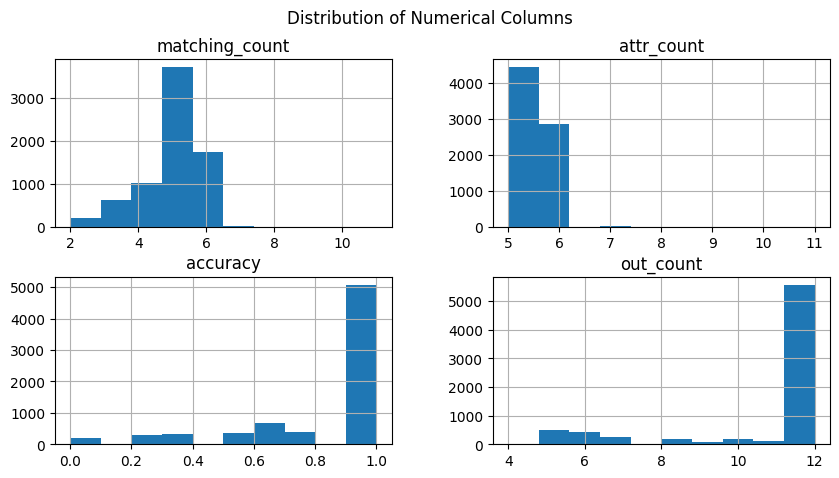

In [75]:
import matplotlib.pyplot as plt

df[df['attr_count'] >= 5].hist(bins=10, figsize=(10, 5))
plt.suptitle("Distribution of Numerical Columns")
plt.show()

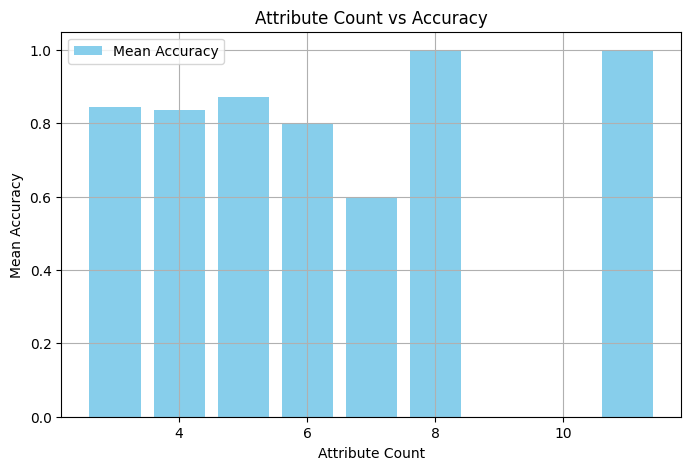

In [76]:
mean_accuracy = df.groupby('attr_count')['accuracy'].mean().reset_index()

plt.figure(figsize=(8, 5))
plt.bar(mean_accuracy['attr_count'], mean_accuracy['accuracy'], color='skyblue', label='Mean Accuracy')
plt.title('Attribute Count vs Accuracy')
plt.xlabel('Attribute Count')
plt.ylabel('Mean Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Calculate Recall and Precision

In [77]:
# True Positives (TP) = matched correctly
# False Positives (FP) = matched and shoudn't
# False Negatives (FN) = didn't match and should

df['false_positives'] = df['out_count'] - df['matching_count']
df['false_negatives'] = df['attr_count'] - df['matching_count']

# Precision = TP / (TP + FP)
precision = df['matching_count'].sum() / (df['matching_count'].sum() + df['false_positives'].sum())

# Recall = TP / (TP + FN)
recall = df['matching_count'].sum() / (df['matching_count'].sum() + df['false_negatives'].sum())

# F1 Score = 2 * (Precision * Recall) / (Precision + Recall)
f1_score = 2 * (precision * recall) / (precision + recall)

In [78]:
precision

np.float64(0.3773929173284192)

In [79]:
recall

np.float64(0.9111624979876184)

In [80]:
f1_score

np.float64(0.5337236865229561)

In [81]:
df['matching_count'].sum() #TP

np.int64(62257)

In [82]:
 df['false_positives'].sum()

np.int64(102709)

### Calculating relevance_to_set to improve true positives marking
if an attribute is suggested and not in the original schema but still relevant to the schema

In [96]:
from itertools import product

def max_similarity(word1, word2):
    synsets1 = wn.synsets(word1)
    synsets2 = wn.synsets(word2)
    
    max_sim = 0
    for syn1, syn2 in product(synsets1, synsets2):
        sim = syn1.wup_similarity(syn2)
        if sim is not None and sim > max_sim:
            max_sim = sim
    return max_sim

def relevance_to_set(target_word, word_set):
    total_similarity = 0
    for word in word_set:
        similarity = max_similarity(target_word, word)
        if similarity is not None:
            total_similarity += similarity

    relevance_score = total_similarity / len(word_set)
    return relevance_score

word_set = ['City', 'Seating Capacity', 'Stadium']
target_word = 'Team'

relevance_score = relevance_to_set(target_word, word_set)
print(f"The relevance of '{target_word}' to the set {word_set} is: {relevance_score}")

The relevance of 'Team' to the set ['City', 'Seating Capacity', 'Stadium'] is: 0.24175824175824176


In [97]:
def get_relevance_to_set(row):
    out_schema_set = sorted({a for a in row['out_schema']})
    schema_set = sorted({a for a in row['schema']})
    attributes_sim = {}
    
    for attr in out_schema_set:
        attributes_sim[attr] = relevance_to_set(attr, schema_set)
    
    return attributes_sim

In [102]:
df['out_schema_sim'] = df.apply(get_relevance_to_set, axis=1)
df

,schema,url,title,test_input,test_output,out_schema,matching_count,attr_count,accuracy,matching_pairs,out_count,false_positives,false_negatives,out_schema_sim
0,"[Year, Award, Result, Category/Recipient]",https://en.wikipedia.org/wiki/List_of_awards_w...,List of awards won by Andrei Tarkovsky,"[Category/Recipient, Award]","[(Category, 35.38182447311458), (Result, 27.46...","[Category/Recipient, Award, Category, Result, ...",4,4,1.000000,"[(Award, Award), (Category/Recipient, Category...",12,8,0,"{'Achievement': 0.3760302197802198, 'Award': 0..."
1,"[Player, Nationality, Int . cap / goal, Club c...",https://en.wikipedia.org/wiki/Al_Sadd_SC,Al Sadd SC,"[Int . cap / goal, Club cap / goal]","[(Player, 0.7254077840258099), (Nationality, 0...","[Int . cap / goal, Club cap / goal, Player, Na...",4,4,1.000000,"[(Club cap / goal, Club cap / goal), (Int . ca...",4,0,0,"{'Club cap / goal': 0.0, 'Int . cap / goal': 0..."
2,"[Name, M, G, Degree, Note]",https://en.wikipedia.org/wiki/List_of_politici...,"List of politicians, lawyers, and civil servan...","[Degree, G]","[(Notability, 74.44898030914881), (Clas year, ...","[Degree, G, Notability, Clas year, M, Name, No...",5,5,1.000000,"[(Degree, Degree), (G, G), (M, M), (Name, Name...",12,7,0,"{'A': 0.6744444444444444, 'Clas year': 0.0, 'D..."
3,"[#, Title, Co-Star, Release Date, Director, Se...",https://en.wikipedia.org/wiki/Looney_Tunes_Sup...,Looney Tunes Super Stars' Bugs Bunny: Hare Ext...,"[Co-Star, Release Date]","[(Publisher, 56.47905788895884), (CERO, 35.740...","[Co-Star, Release Date, Publisher, CERO, Title...",3,6,0.250000,"[(Co-Star, Co-Star), (Release Date, Release Da...",12,9,3,"{'CERO': 0.1889605734767025, 'Co-Star': 0.3486..."
4,"[Conference, Nickname, Founded, Member, Sport,...",https://en.wikipedia.org/wiki/List_of_NCAA_con...,List of NCAA conferences,"[Conference, Member]","[(School, 33.902651669686755), (Party, 22.6575...","[Conference, Member, School, Party, Electoral ...",5,6,0.750000,"[(Conference, Conference), (Founded, Founded),...",12,7,1,"{'Conference': 0.5547008547008547, 'Election d..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15268,"[Title, Publisher, Developer, Release Date, ESRB]",https://en.wikipedia.org/wiki/List_of_Virtual_...,List of Virtual Console games for Wii U (North...,"[ESRB, Release Date]","[(Publisher, 56.47905788895884), (CERO, 35.740...","[ESRB, Release Date, Publisher, CERO, Title, D...",5,5,1.000000,"[(Developer, Developer), (ESRB, ESRB), (Publis...",12,7,0,"{'CERO': 0.18447290640394087, 'Developer': 0.3..."
15269,"[Club, Qualified, Champion, Runners-up, Season]",https://en.wikipedia.org/wiki/List_of_clubs_in...,List of clubs in the German football championship,"[Qualified, Champion]","[(Runner-up, 43.40284463464052), (Runners-up, ...","[Qualified, Champion, Runner-up, Runners-up, T...",4,5,0.666667,"[(Champion, Champion), (Qualified, Qualified),...",12,8,1,"{'Champion': 0.6204334365325078, 'Goal': 0.431..."
15270,"[#, Name on the Register, Date listed, Locatio...",https://en.wikipedia.org/wiki/National_Registe...,National Register of Historic Places listings ...,"[Name on the Register, Date listed]","[(City or town, 289.5942555325688), (Location,...","[Name on the Register, Date listed, City or to...",5,5,1.000000,"[(#, #), (City or town, City or town), (Date l...",12,7,0,"{'#': 0.0, 'Barrio': 0.13333333333333333, 'Cit..."
15271,"[Season, Player, NBA team, Date called up and ...",https://en.wikipedia.org/wiki/Iowa_Wolves,Iowa Wolves,"[Date called up and contract signed, NBA team]","[(Season, 2.421460038404703), (Date called-up ...","[Date called up and contract signed, NBA team,...",4,4,1.000000,"[(Date called up and contract signed, Date cal...",7,3,0,"{'Date assigned': 0.0, 'Date called up and con..."


In [104]:
def count_relevant_items(row):
    counter = 0
    
    for key, value in row['out_schema_sim'].items():
        if value >= 0.5:
            counter += 1
    
    return counter

In [105]:
df['relevant_count'] = df.apply(count_relevant_items, axis = 1)
df

,schema,url,title,test_input,test_output,out_schema,matching_count,attr_count,accuracy,matching_pairs,out_count,false_positives,false_negatives,out_schema_sim,relevant_count
0,"[Year, Award, Result, Category/Recipient]",https://en.wikipedia.org/wiki/List_of_awards_w...,List of awards won by Andrei Tarkovsky,"[Category/Recipient, Award]","[(Category, 35.38182447311458), (Result, 27.46...","[Category/Recipient, Award, Category, Result, ...",4,4,1.000000,"[(Award, Award), (Category/Recipient, Category...",12,8,0,"{'Achievement': 0.3760302197802198, 'Award': 0...",0
1,"[Player, Nationality, Int . cap / goal, Club c...",https://en.wikipedia.org/wiki/Al_Sadd_SC,Al Sadd SC,"[Int . cap / goal, Club cap / goal]","[(Player, 0.7254077840258099), (Nationality, 0...","[Int . cap / goal, Club cap / goal, Player, Na...",4,4,1.000000,"[(Club cap / goal, Club cap / goal), (Int . ca...",4,0,0,"{'Club cap / goal': 0.0, 'Int . cap / goal': 0...",0
2,"[Name, M, G, Degree, Note]",https://en.wikipedia.org/wiki/List_of_politici...,"List of politicians, lawyers, and civil servan...","[Degree, G]","[(Notability, 74.44898030914881), (Clas year, ...","[Degree, G, Notability, Clas year, M, Name, No...",5,5,1.000000,"[(Degree, Degree), (G, G), (M, M), (Name, Name...",12,7,0,"{'A': 0.6744444444444444, 'Clas year': 0.0, 'D...",6
3,"[#, Title, Co-Star, Release Date, Director, Se...",https://en.wikipedia.org/wiki/Looney_Tunes_Sup...,Looney Tunes Super Stars' Bugs Bunny: Hare Ext...,"[Co-Star, Release Date]","[(Publisher, 56.47905788895884), (CERO, 35.740...","[Co-Star, Release Date, Publisher, CERO, Title...",3,6,0.250000,"[(Co-Star, Co-Star), (Release Date, Release Da...",12,9,3,"{'CERO': 0.1889605734767025, 'Co-Star': 0.3486...",0
4,"[Conference, Nickname, Founded, Member, Sport,...",https://en.wikipedia.org/wiki/List_of_NCAA_con...,List of NCAA conferences,"[Conference, Member]","[(School, 33.902651669686755), (Party, 22.6575...","[Conference, Member, School, Party, Electoral ...",5,6,0.750000,"[(Conference, Conference), (Founded, Founded),...",12,7,1,"{'Conference': 0.5547008547008547, 'Election d...",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15268,"[Title, Publisher, Developer, Release Date, ESRB]",https://en.wikipedia.org/wiki/List_of_Virtual_...,List of Virtual Console games for Wii U (North...,"[ESRB, Release Date]","[(Publisher, 56.47905788895884), (CERO, 35.740...","[ESRB, Release Date, Publisher, CERO, Title, D...",5,5,1.000000,"[(Developer, Developer), (ESRB, ESRB), (Publis...",12,7,0,"{'CERO': 0.18447290640394087, 'Developer': 0.3...",0
15269,"[Club, Qualified, Champion, Runners-up, Season]",https://en.wikipedia.org/wiki/List_of_clubs_in...,List of clubs in the German football championship,"[Qualified, Champion]","[(Runner-up, 43.40284463464052), (Runners-up, ...","[Qualified, Champion, Runner-up, Runners-up, T...",4,5,0.666667,"[(Champion, Champion), (Qualified, Qualified),...",12,8,1,"{'Champion': 0.6204334365325078, 'Goal': 0.431...",3
15270,"[#, Name on the Register, Date listed, Locatio...",https://en.wikipedia.org/wiki/National_Registe...,National Register of Historic Places listings ...,"[Name on the Register, Date listed]","[(City or town, 289.5942555325688), (Location,...","[Name on the Register, Date listed, City or to...",5,5,1.000000,"[(#, #), (City or town, City or town), (Date l...",12,7,0,"{'#': 0.0, 'Barrio': 0.13333333333333333, 'Cit...",0
15271,"[Season, Player, NBA team, Date called up and ...",https://en.wikipedia.org/wiki/Iowa_Wolves,Iowa Wolves,"[Date called up and contract signed, NBA team]","[(Season, 2.421460038404703), (Date called-up ...","[Date called up and contract signed, NBA team,...",4,4,1.000000,"[(Date called up and contract signed, Date cal...",7,3,0,"{'Date assigned': 0.0, 'Date called up and con...",0


In [111]:
df.iloc[1]['schema']

['Player', 'Nationality', 'Int . cap / goal', 'Club cap / goal']

In [112]:
df.iloc[1]['out_schema_sim']

{'Club cap / goal': 0.0,
 'Int . cap / goal': 0.0,
 'Nationality': 0.3,
 'Player': 0.3}